In [1]:
from pathlib import Path

import gzip
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

In [2]:
root_dir = Path('.').resolve(strict=True).parent
data_dir = root_dir / 'data'

In [3]:
def fetch(file_name):
    with gzip.open(data_dir / file_name, 'rb') as file:
        array = np.frombuffer(file.read(), np.uint8)
    return array.copy()


x_train = fetch('train-images-idx3-ubyte.gz')[16:].reshape((-1, 28, 28))
y_train = fetch('train-labels-idx1-ubyte.gz')[8:]
x_test = fetch('t10k-images-idx3-ubyte.gz')[16:].reshape((-1, 28, 28))
y_test = fetch('t10k-labels-idx1-ubyte.gz')[8:]

In [4]:
bs = 128
lr = 0.001
epochs = 1000
loss_func = F.cross_entropy

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        return x


model = CNN()
opt = optim.Adam(model.parameters(), lr=lr)

loss 0.10 accuracy 0.97: 100%|██████████| 1000/1000 [00:47<00:00, 21.10it/s]


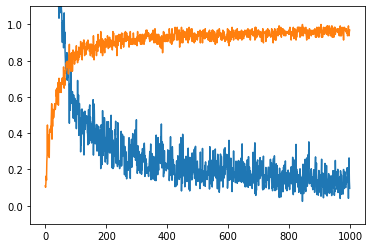

In [6]:
accuracies = []
losses = []

for epoch in (t := trange(epochs)):
    samp = np.random.randint(0, len(x_train), size=(bs))
    x = Tensor(x_train[samp].reshape((-1, 28*28))).float()
    y = Tensor(y_train[samp]).long()

    out = model(x)
    pred = torch.argmax(out, dim=1)
    accuracy = (pred == y).float().mean()
    loss = loss_func(out, y)

    loss.backward()
    opt.step()
    opt.zero_grad()

    t.set_description(f'loss {loss:.2f} accuracy {accuracy:.2f}')
    accuracies.append(accuracy.item())
    losses.append(loss.item())

plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [7]:
pred = torch.argmax(model(Tensor(x_test).float()), dim=1).numpy()
(pred == y_test).mean()

0.9557